In [2]:
import pandas as pd
import librosa
import os
import numpy as np 
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

In [3]:
from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint 
from keras.regularizers import l2

In [7]:
import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

ModuleNotFoundError: No module named 'torch'

In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [1]:
import tensorflow as  tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


ModuleNotFoundError: No module named 'tensorflow'

## Arquivo de metadados

In [3]:
audio_path = 'spectogram/'
spectograms = os.listdir(audio_path)

#metadata with most_freq chords indicator
df = pd.read_csv('metadata_final.csv', sep = ',')
df_chords = df[df['most_freq'] == 1]


## Mel Spectogram

In [144]:
X = np.load("X-mel_spec.npy")
y = np.load("y-mel_spec.npy")

In [145]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [146]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))


mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [9]:
X_train.shape

(755, 40, 608)

## Custom Model

In [112]:
import mlflow

mlflow.tensorflow.autolog(every_n_iter = 2)

2023/10/22 17:16:05 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [113]:
# How data should be structured
num_rows = 608
num_columns = 40 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

In [114]:
def create_model():

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model


model = create_model()

In [137]:
model.compile(
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy()],  
    optimizer='adam')

# Display model architecture summary 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 606, 38, 32)       320       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 606, 38, 32)       0         
                                                                 
 batch_normalization_4 (Bat  (None, 606, 38, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 604, 36, 32)       9248      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 604, 36, 32)       0         
                                                                 
 batch_normalization_5 (Bat  (None, 604, 36, 32)       128       
 chNormalization)                                     

In [138]:
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=4, 
                    epochs=10, 
                    validation_data=(X_test,y_test_encoded),
                    verbose=1)

2023/10/22 17:37:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c7f7402a7173453cba3f7bc697e438d8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
189/189 [==============================] - 55s 282ms/step - loss: 2.0289 - categorical_accuracy: 0.2477 - val_loss: 2.3348 - val_categorical_accuracy: 0.1769
Epoch 2/10
189/189 [==============================] - 53s 283ms/step - loss: 2.0237 - categorical_accuracy: 0.2596 - val_loss: 2.1931 - val_categorical_accuracy: 0.1984
Epoch 3/10
189/189 [==============================] - 53s 282ms/step - loss: 1.9812 - categorical_accuracy: 0.2874 - val_loss: 2.0849 - val_categorical_accuracy: 0.2198
Epoch 4/10
189/189 [==============================] - 52s 277ms/step - loss: 1.9735 - categorical_accuracy: 0.2715 - val_loss: 2.1281 - val_categorical_accuracy: 0.2145
Epoch 5/10
189/189 [==============================] - 55s 289ms/step - loss: 1.9601 - categorical_accuracy: 0.2874 - val_loss: 2.1150 - val_categorical_accuracy: 0.2413
Epoch 6/10
189/189 [==============================] - 51s 270ms/step - loss: 1.9047 - categorical_accuracy: 0.3113 - val_loss: 2.5210 - val_categorical_acc

INFO:tensorflow:Assets written to: C:\Users\alves\AppData\Local\Temp\tmphuyijldf\model\data\model\assets


## Metrics

In [139]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

preds_score = model.predict(X_test)
pred_idx = tf.math.argmax(preds_score, axis = 1)
y_test_idx = tf.math.argmax(y_test_encoded, axis = 1)
target_names = mapping.keys()

print('F1-Score: ', f1_score(y_test_idx, pred_idx, average = 'macro'))
print('F1-Score: ', f1_score(y_test_idx, pred_idx, average = 'macro'))

print(classification_report(y_test_idx, pred_idx, target_names= target_names))


12/12 [==============================] - 4s 341ms/step
F1-Score:  0.22631273662309548
F1-Score:  0.22631273662309548
              precision    recall  f1-score   support

      A#:maj       0.25      0.07      0.11        27
      C#:maj       0.67      0.26      0.37        39
       C:maj       0.14      0.62      0.23        37
      D#:maj       0.17      0.04      0.06        27
       D:maj       0.46      0.32      0.38        37
       E:maj       0.80      0.22      0.34        37
      F#:maj       0.67      0.06      0.11        33
       F:maj       0.34      0.24      0.28        50
      G#:maj       0.50      0.05      0.09        39
       G:maj       0.20      0.45      0.28        47

    accuracy                           0.25       373
   macro avg       0.42      0.23      0.23       373
weighted avg       0.42      0.25      0.24       373



In [35]:
from sklearn.metrics import f1_score
import tensorflow as tf
#print('Acurácia: ', f1_score(y_test, preds))

<tf.Tensor: shape=(373,), dtype=int64, numpy=
array([4, 1, 2, 1, 0, 7, 1, 3, 6, 4, 6, 4, 6, 7, 5, 8, 5, 8, 3, 8, 5, 0,
       0, 7, 7, 1, 3, 3, 7, 2, 5, 7, 3, 2, 9, 5, 4, 4, 3, 4, 3, 9, 0, 6,
       5, 8, 9, 1, 3, 4, 7, 8, 8, 1, 5, 4, 7, 1, 7, 7, 4, 9, 9, 0, 9, 7,
       8, 9, 9, 3, 1, 1, 7, 9, 0, 7, 7, 1, 8, 2, 8, 9, 7, 5, 1, 0, 7, 5,
       1, 1, 5, 4, 2, 8, 0, 7, 9, 5, 1, 6, 9, 5, 8, 9, 4, 8, 2, 6, 9, 0,
       9, 2, 5, 4, 7, 7, 3, 6, 0, 9, 6, 5, 6, 3, 1, 5, 3, 1, 2, 4, 7, 5,
       9, 2, 8, 2, 4, 6, 2, 6, 9, 4, 3, 1, 4, 9, 1, 4, 8, 9, 5, 6, 6, 7,
       7, 1, 3, 7, 3, 8, 2, 7, 1, 6, 5, 9, 4, 2, 8, 6, 9, 2, 2, 6, 0, 5,
       2, 8, 0, 8, 8, 0, 5, 0, 7, 4, 7, 5, 1, 9, 2, 9, 7, 8, 0, 4, 7, 3,
       3, 7, 0, 9, 6, 2, 9, 3, 0, 9, 9, 6, 4, 1, 3, 2, 7, 4, 4, 9, 8, 6,
       1, 7, 1, 5, 0, 1, 8, 2, 2, 6, 7, 1, 7, 7, 6, 1, 2, 4, 1, 7, 3, 1,
       8, 4, 9, 4, 9, 7, 8, 5, 8, 4, 9, 2, 9, 2, 8, 7, 1, 4, 1, 4, 2, 1,
       0, 0, 1, 8, 2, 2, 6, 6, 4, 9, 7, 4, 7, 5, 3, 4, 5, 7, 9, 5, 5, 9,
     

## MobileNet

In [10]:
#ref -> https://www.tensorflow.org/tutorials/images/transfer_learning?hl=pt-br

In [141]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


In [142]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [4]:
import mlflow

mlflow.tensorflow.autolog(every_n_iter = 2)

2023/10/22 16:20:21 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [147]:
import tensorflow as tf

IMG_SHAPE = (X_train.shape[1], X_train.shape[2],3)


def add_channels(array):

    arr = np.expand_dims(array, axis = -1)
    # pad the missing dims with zeros
    pad = ((0,0),)*3 + ((0,2),)
    padded = np.pad(arr, pad, 'constant', constant_values = 0)

    return padded

X_train_mobile = add_channels(X_train)
X_test_mobile = add_channels(X_test)


base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [148]:

feature_batch = base_model(X_train_mobile)
print(feature_batch.shape)


(755, 2, 19, 1280)


In [149]:
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)


In [150]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 40, 608, 3)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 20, 304, 32)          864       ['input_12[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 20, 304, 32)          128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 20, 304, 32)          0         ['bn_Conv1[

In [151]:
prediction_layer = tf.keras.layers.Dense(10, activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)

In [152]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [153]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [154]:
len(model.trainable_variables)


2

In [155]:
initial_epochs = 10

history = model.fit(X_train_mobile, y_train_encoded,
                    epochs=initial_epochs,
                    validation_data=(X_test_mobile, y_test_encoded))



2023/10/22 17:53:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2e1b985c1eba41db83442984e7259f1f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
24/24 [==============================] - 17s 604ms/step - loss: 3.0692 - categorical_accuracy: 0.0954 - val_loss: 2.6487 - val_categorical_accuracy: 0.0724
Epoch 2/10
24/24 [==============================] - 13s 571ms/step - loss: 2.6283 - categorical_accuracy: 0.1060 - val_loss: 2.3960 - val_categorical_accuracy: 0.0724
Epoch 3/10
24/24 [==============================] - 14s 592ms/step - loss: 2.5026 - categorical_accuracy: 0.1033 - val_loss: 2.3225 - val_categorical_accuracy: 0.1019
Epoch 4/10
24/24 [==============================] - 14s 583ms/step - loss: 2.4922 - categorical_accuracy: 0.0954 - val_loss: 2.3054 - val_categorical_accuracy: 0.1367
Epoch 5/10
24/24 [==============================] - 14s 588ms/step - loss: 2.5150 - categorical_accuracy: 0.0861 - val_loss: 2.3011 - val_categorical_accuracy: 0.1340
Epoch 6/10
24/24 [==============================] - 14s 580ms/step - loss: 2.4793 - categorical_accuracy: 0.0927 - val_loss: 2.2981 - val_categorical_accuracy: 0.134

INFO:tensorflow:Assets written to: C:\Users\alves\AppData\Local\Temp\tmpn6nhptn5\model\data\model\assets


In [87]:
y_train_encoded.shape

(755, 10)

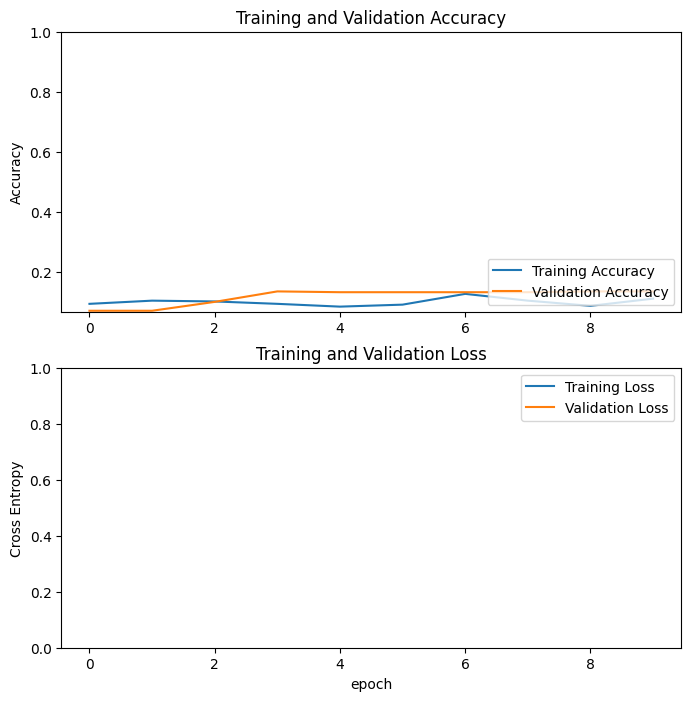

In [158]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
